In [12]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


I will start with the easy web scraper like pd-reader. I think at the end I will try the websocket to do the scraper from trading view.

Please search the name of the asset in https://finance.yahoo.com/ first!
Which asset do you want to check for the performance (e.g. BTC-USD TSLA (max = 8 assets)):


 DOGE-USD BTC-USD


start date (e.g. 2022/04/04):


 2019-1-1


end date:


 2022-4-4


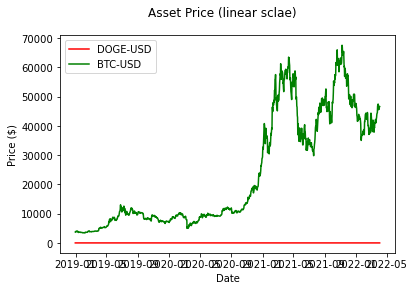

volatilty: Symbols
DOGE-USD    1719.575171
BTC-USD      176.474439
dtype: float64

return-risk-ratio
DOGE-USD 0.036251990388064995
BTC-USD 0.06492136594695935

maximum drawn down: [Symbols
DOGE-USD   -0.997755
BTC-USD    -0.949687
dtype: float64, Symbols
DOGE-USD   -0.997755
BTC-USD    -0.949687
dtype: float64]

GMV portfolio: Returns       0.002867
Volatility    5.113590
DOGE-USD      0.000000
BTC-USD       1.000000
Name: 72, dtype: float64

MSR portfolio: Returns       0.002867
Volatility    5.113590
DOGE-USD      0.000000
BTC-USD       1.000000
Name: 72, dtype: float64


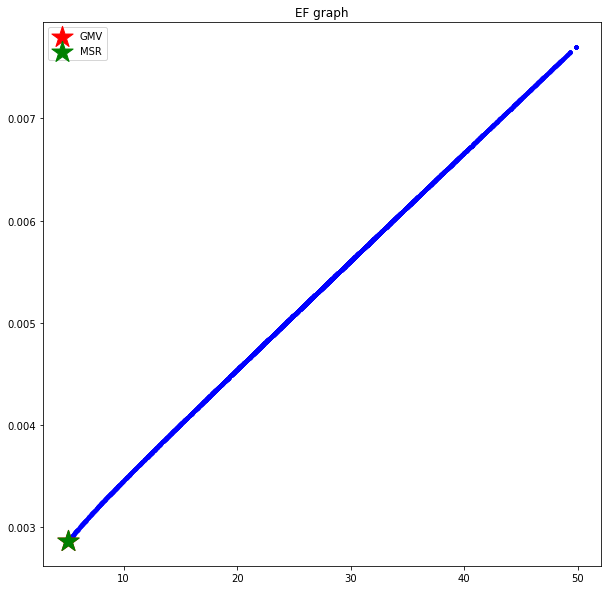

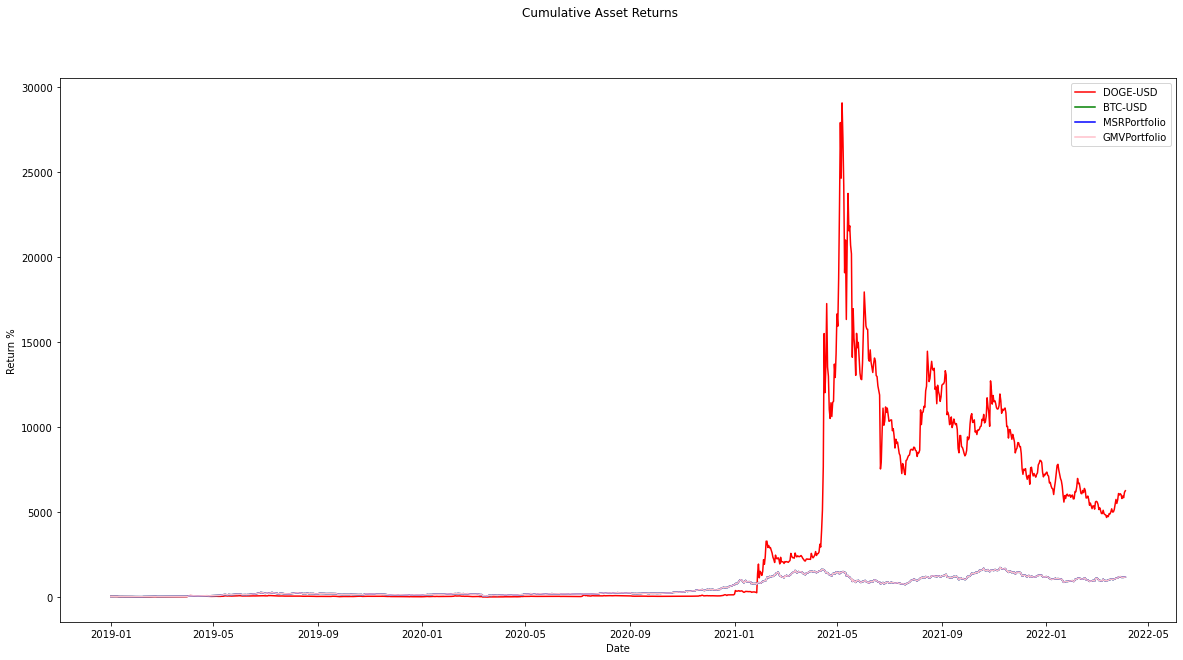

In [4]:
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
%matplotlib inline
from cycler import cycler
import seaborn as sns
import random

print('Please search the name of the asset in https://finance.yahoo.com/ first!')
print('Which asset do you want to check for the performance (e.g. BTC-USD TSLA (max = 8 assets)):')
a = input().split()
b = []
for i in a:
    b.append(i)
print('start date (e.g. 2022/04/04):')
x = input()
print('end date:')
y = input()

# When developing, I used this code to not input the data everytime.
# a = 'BTC-USD FB ETH-USD'
# a = a.split()
# b = []
# for i in a:
#     b.append(i)
# x = '2020-1-1'
# y = '2022-4-4'

asset = data.DataReader(a, 'yahoo', start=x, end=y)
asset.head()

asset_close = asset['Adj Close']
# asset_close = asset_close.set_index('Date')
asset_num = len(asset_close.columns)
day = len(asset_close)

asset_return = asset_close.pct_change()
asset_return = asset_return.dropna()
asset_cum_return = asset_return.apply(lambda x: ((x + 1).cumprod() - 1))

plt.rc('axes', prop_cycle=(cycler('color', ['red', 'green', 'blue', 'pink', 'orange','#D95319','#77AC30','#4DBEEE',[0.75, 0.75, 0],[0.6350, 0.0780, 0.1840]])))

std_figure_size = (10, 10)
fig, ax = plt.subplots()
for name in asset_close.columns:
    ax.plot(asset_close.index,asset_close[name], label = name)
plt.legend()
fig.suptitle('Asset Price (linear sclae)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()

# std_figure_size = (10, 10)
# fig, ax = plt.subplots()
# for name in asset_return.columns:
#     ax.plot(asset_return.index,asset_return[name], label = name)
# plt.legend()
# fig.suptitle('Asset returns')
# plt.xlabel('Date')
# plt.ylabel('returns (%)')
# plt.show()

#Return
asset_mean_ret = np.mean(asset_return)
total_ret = asset_cum_return.iloc[-1]

# volatility
length = len(asset_close)
asset_vol = asset_cum_return.std().apply(lambda x: x*np.sqrt(length))
print('volatilty:', asset_vol)
print('')

print('return-risk-ratio')
for name in asset_close.columns:
    print(name, total_ret[name]/asset_vol[name])

print('')

# max draw down
max_drawn = []
for name in asset_close.columns:
    max_asset = asset_close.max()
    min_asset = asset_close.min()
    Max_Daily_Drawdown = min_asset/max_asset - 1.0
    max_drawn.append(Max_Daily_Drawdown)
print('maximum drawn down:', max_drawn)
print('')

# portfolio analysis
cov_matrix = asset_cum_return.cov()
# weight generation
# I think grid method is better
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights

num_portfolios = 10000
def Rand(start, end, num):
    res = []
    for j in range(num):
        res.append(random.randint(start, end))
    return res

for portfolio in range(num_portfolios):
    weights = Rand(0,101,asset_num)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, asset_mean_ret) # Returns are the product of individual expected returns   								   			   # of asset and its weights 
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
                # Portfolio Variance
    vol = np.sqrt(var) # monthly standard deviation = volrality
    p_vol.append(vol)
    
data = {'Returns':p_ret, 'Volatility':p_vol}


for counter, symbol in enumerate(asset_return.columns.tolist()):
    #print(counter, symbol)
    data[symbol] = [w[counter] for w in p_weights] # add new column for weight of each 
portfolios  = pd.DataFrame(data)

GMV = portfolios.iloc[portfolios['Volatility'].idxmin()]
print('GMV portfolio:', GMV)
print('')

MSR = portfolios.iloc[((portfolios['Returns'])/portfolios['Volatility']).idxmax()]
print('MSR portfolio:', MSR)

plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', color = 'blue', s=10, alpha=0.3)
plt.scatter(GMV[1], GMV[0], color='red', marker='*', s=500, label='GMV')
plt.scatter(MSR[1], MSR[0], color='green', marker='*', s=500, label='MSR')
plt.title('EF graph')
plt.legend()

MSR_weights = MSR[2:]
asset_return['MSRPortfolio'] = asset_return.mul(np.array(MSR_weights), axis=1).sum(axis=1)

GMV_weights = GMV[2:]
asset_return['GMVPortfolio'] = asset_return.iloc[:,:-1].mul(np.array(GMV_weights), axis=1).sum(axis=1)
    
# returns_df['MSR'] = returns_df['btc returns'] * MSR1['btc returns weight'] + returns_df['sp500 returns'] * MSR1['sp500 returns weight'] + returns_df['gold returns'] * MSR1['gold returns weight']

cum_returns_df = ((1+asset_return).cumprod() - 1) * 100
fig, ax = plt.subplots(figsize=(20,10))
fig.suptitle('Cumulative Asset Returns')
label_position = 'upper left'
for name in cum_returns_df:
    ax.plot(cum_returns_df[name], label=name)
ax.legend()
plt.xlabel('Date')
plt.ylabel('Return %')
plt.show()